In [8]:
import os, sys
import pickle
import polars as pl

In [9]:
# Define el ID del experimento que quieres analizar
DATA_ID = 'simulation_testing' 
N_REALIZATIONS = 100

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) 
results_dir = os.path.join(project_path, 'results', 'experiment_4b', DATA_ID)
filename = f'results_exp_4b_{DATA_ID}.pkl'
results_path = os.path.join(results_dir, filename)

sys.path.append(project_path)

from src.experiments_utils import plot_experiment_4_results
#from config.config_experiment_3 import N_REALIZATIONS

In [10]:
# -------------------------------------------------------------------------
# CARGAR RESULTADOS
# -------------------------------------------------------------------------
if not os.path.exists(results_path):
    print("❌ Error: El archivo no existe. Revisa el DATA_ID o la ruta.")
else:
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print(f"✅ Archivo cargado correctamente. Tipo de objeto: {type(results)}")
    print(f"📊 Número de realizaciones (seeds) capturadas: {len(results)}")

# -------------------------------------------------------------------------
# CONVERSIÓN A DATAFRAME  
# -------------------------------------------------------------------------
rows = []
for seed, metrics in results.items():   
    # Asumimos que todas las métricas tienen las mismas claves (frac_sample_sizes)
    model_names_arr = metrics['ARI'].keys() 
    
    for model_name in model_names_arr:        
        row = {
            'random_state': seed,
            'model_name': model_name,
            'time': metrics['time'].get(model_name),
            'adj_accuracy': metrics['adj_accuracy'].get(model_name),
            'ARI': metrics['ARI'].get(model_name),
            'status': metrics['status'].get(model_name) if 'status' in metrics else 'OK'
        }
        rows.append(row)

df = pl.DataFrame(rows)

df = df.with_columns(
    pl.when(
        pl.col('status').str.contains('Error')
    ).then(
        True
    ).otherwise(
        False
    ).alias('status_error')
)

df_avg = (
    df.group_by(['model_name'])
    .agg(
        [pl.mean(c).alias(f'mean_{c}'.lower()) for c in ['ARI', 'adj_accuracy', 'time']] +
        [pl.std(c).alias(f'std_{c}'.lower()) for c in ['ARI', 'adj_accuracy', 'time']] +
        [pl.mean('status_error').alias('prop_status_error')]
    )
    .sort(['mean_adj_accuracy'], descending=True, nulls_last=True)
)

not_feasible_methods = df_avg.filter(pl.col('prop_status_error') >= 0.30)['model_name'].unique().to_list()

'''
not_feasible_methods = ['DipInit', 'SpectralClustering']
rows_to_add = []
for m in not_feasible_methods: 
    if m not in df_avg['model_name'].unique():
        rows_to_add.append({k: None if k != 'model_name' else m for k in df_avg.columns})
df_avg = pl.concat([df_avg, pl.DataFrame(rows_to_add)], how='vertical')
'''

✅ Archivo cargado correctamente. Tipo de objeto: <class 'dict'>
📊 Número de realizaciones (seeds) capturadas: 10


"\nnot_feasible_methods = ['DipInit', 'SpectralClustering']\nrows_to_add = []\nfor m in not_feasible_methods: \n    if m not in df_avg['model_name'].unique():\n        rows_to_add.append({k: None if k != 'model_name' else m for k in df_avg.columns})\ndf_avg = pl.concat([df_avg, pl.DataFrame(rows_to_add)], how='vertical')\n"

In [11]:
df_avg

model_name,mean_ari,mean_adj_accuracy,mean_time,std_ari,std_adj_accuracy,std_time,prop_status_error
str,f64,f64,f64,f64,f64,f64,f64
"""FastKmedoidsGGower-robust_maha…",0.757523,0.89562,1.446164,0.068875,0.031501,0.081705,0.0
"""FastKmedoidsGGower-robust_maha…",0.736668,0.88196,1.433144,0.090988,0.05173,0.092798,0.0
"""FastKmedoidsGGower-robust_maha…",0.72084,0.87788,1.405365,0.080953,0.038339,0.121515,0.0
"""FastKmedoidsGGower-robust_maha…",0.705801,0.8712,1.305646,0.103282,0.048477,0.143675,0.0
"""FoldFastKmedoidsGGower-robust_…",0.708968,0.86552,2.763024,0.100782,0.059374,0.400134,0.0
…,…,…,…,…,…,…,…
"""MiniBatchKMeans""",0.631637,0.69952,0.117172,0.060741,0.073791,0.027949,0.0
"""SpectralCoclustering""",0.593099,0.68872,0.042549,0.066057,0.073178,0.006951,0.0
"""SpectralBiclustering""",0.520338,0.6319,0.566937,0.141867,0.111599,0.060432,0.0


DipInit


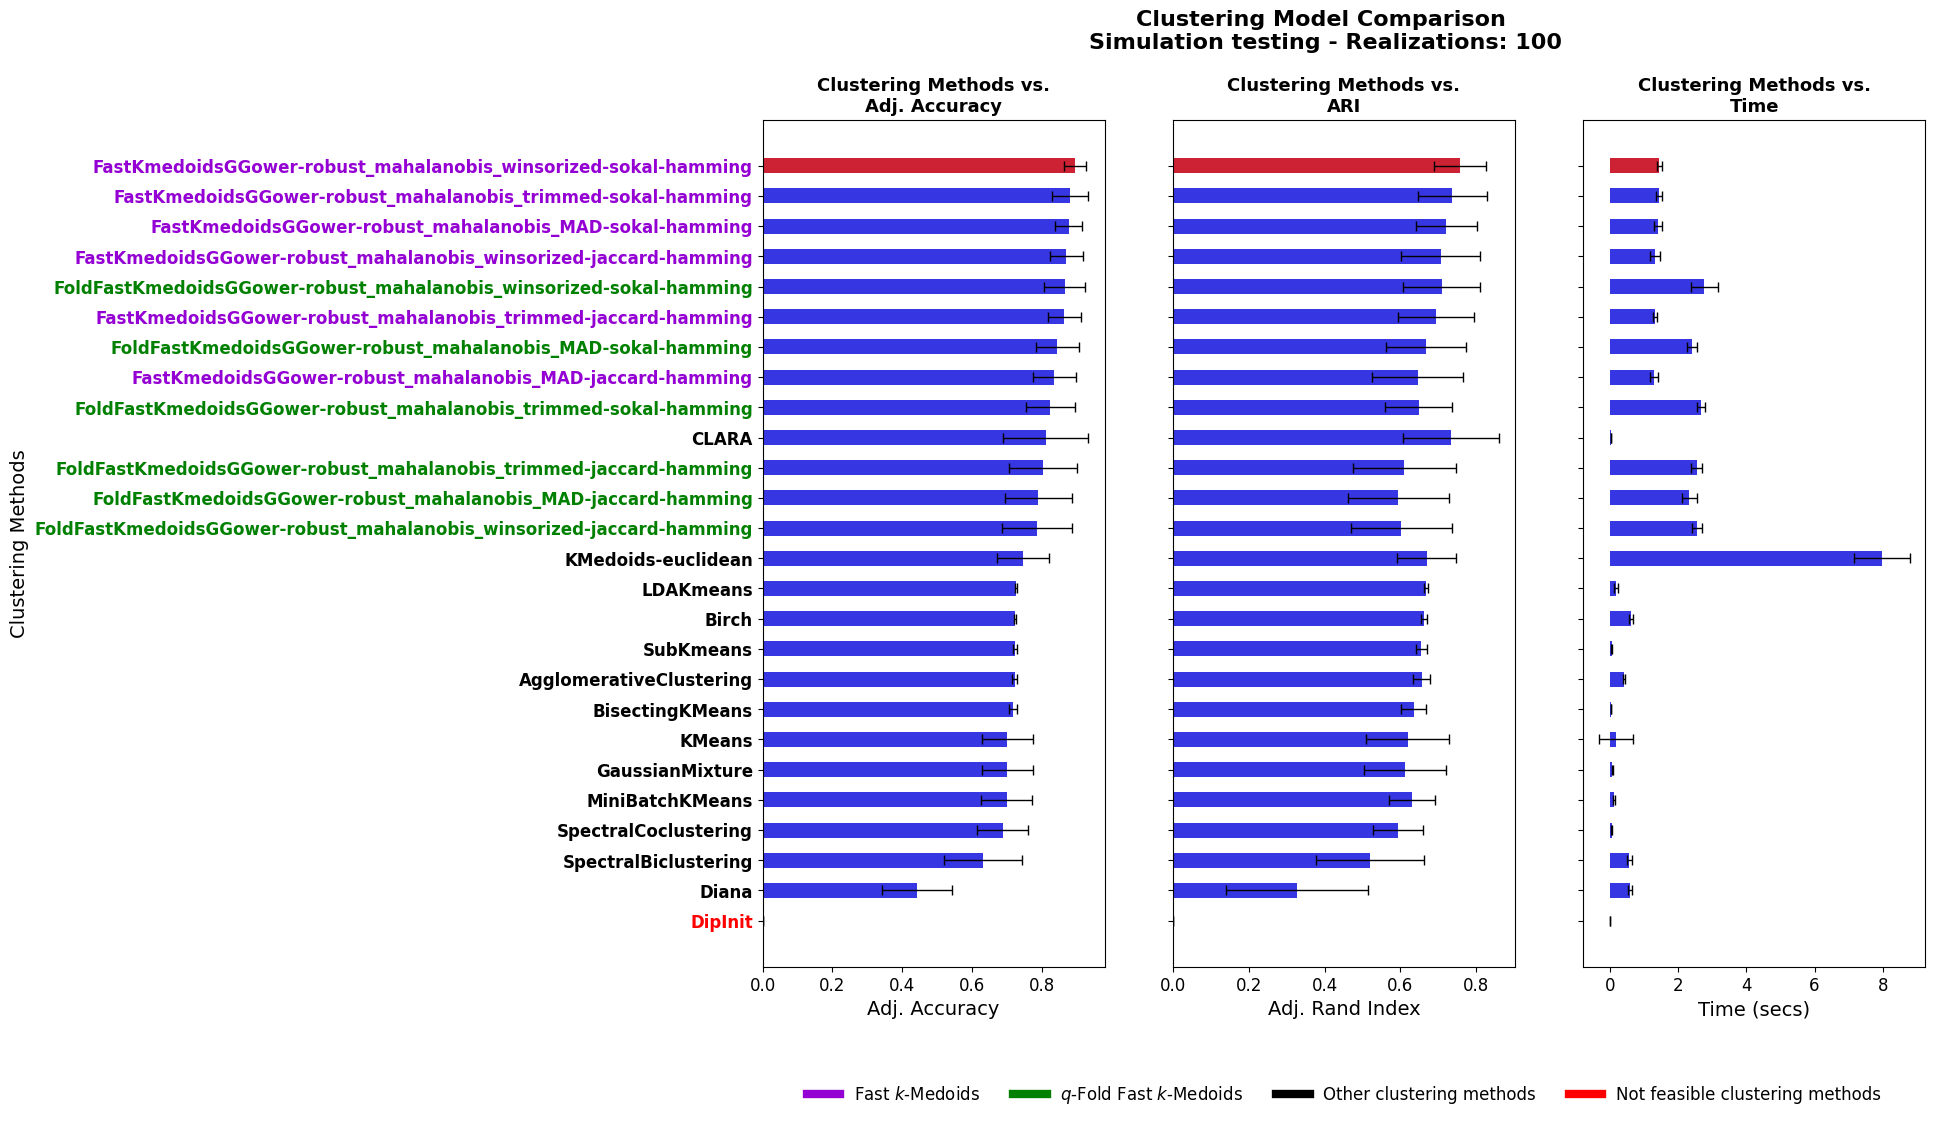

In [12]:
model_names = df_avg['model_name'].unique().to_list()
our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]
plot_filename = f'plot_results_exp_4b_{DATA_ID}.png'
save_path = os.path.join(results_dir, plot_filename)

plot_experiment_4_results(
    df = df_avg, 
    data_name = DATA_ID, 
    num_realizations = 100, 
    save_path = save_path, 
    our_methods_1=our_methods_1, our_methods_2=our_methods_2, 
    other_methods=other_methods, not_feasible_methods=not_feasible_methods)